In [37]:
from __future__ import print_function
import cobra
import os
import libsbml
import pandas as pd
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy

In [2]:
strains = ["CFT073","HM1", "HM3", "HM6", "HM7", "HM14", "HM17", "HM43", "HM54", "HM56","HM57", "HM66", "HM68", "HM86"]
fnames = []
for st in strains:
    PATH="/Users/annasintsova/git_repos/HUTI-RNAseq/analysis/fba/2017-12-16-model-2/data/{}_homologues/{}_model/{}_iML1515.xml".format(st,st,st)
    fnames.append(PATH)
cft, hm01, hm03, hm06, hm07, hm14, hm17, hm43, hm54, hm56, hm57, hm66, hm68, hm86 = map(cobra.io.read_sbml_model, fnames)


In [3]:
models = [cft, hm01, hm03, hm06, hm07, hm14, hm17, hm43, hm54, hm56, hm57, hm66, hm68, hm86]
for mod in models:
    print(mod)
    print(mod.optimize().objective_value)

CFT073_iML1515
0.8581684198787499
HM1_iML1515
0.28493292327334063
HM3_iML1515
0.8769972144269715
HM6_iML1515
0.8769683954878497
HM7_iML1515
0.8769972144269682
HM14_iML1515
0.8769972144269702
HM17_iML1515
0.8769972144269679
HM43_iML1515
0.28492963076401473
HM54_iML1515
0.8769683954878539
HM56_iML1515
0.876968395487846
HM57_iML1515
0.876968395487851
HM66_iML1515
0.876968395487851
HM68_iML1515
0.8769683954878459
HM86_iML1515
0.8650880223392078


In [4]:
carbon_sources = ['acetate exchange', 'succinate exchange', 'acetaldehyde exchange', '2-oxoglutarate exchange',
                 'ethanol exchange', 'fumarate exchange', 'd-fructose exchange', 'd-glucose exchange', 'l-glutamine exchange', 
                 'l-glutamate exchange', 'd-lactate exchange', 'l-malate exchange', 'pyruvate exchange']

In [5]:
def simulateCarbonSources(strains, models, carbon_sources=''):

    colnames = []
    aerobic_results = []
    anaerobic_results = []
    out_dir = "/Users/annasintsova/git_repos/"\
                "HUTI-RNAseq/analysis/fba/2017-12-16-model-2/"\
                    "data/"
    for st, mod in zip(strains, models):
        colnames.append(mod)
        exchange_subs = {}      
        for rex in mod.reactions:
            if "EX_" in rex.id:
                exchange_subs[rex.name]=rex.id
                
        glc = mod.reactions.EX_glc__D_e
        glc.lower_bound = 0.0
        ox = mod.reactions.EX_o2_e
        aerobic_biomass = {}
        anaerobic_biomass ={}
        
        for key, val in exchange_subs.items():
            if carbon_sources:
                if key.lower() in carbon_sources:
                    cs = mod.reactions.get_by_id(val)
                    original_lower_bound = cs.lower_bound
                    cs.lower_bound = -10
                    obj = round(mod.optimize().objective_value,4)
                    aerobic_biomass[key] = obj if obj > 0 else 0
                    ox.lower_bound = 0.0
                    obj = round(mod.optimize().objective_value,4)
                    anaerobic_biomass[key] = obj if obj > 0 else 0
                    cs.lower_bound = original_lower_bound
                    ox.lower_bound = -1000.0
            else:
                cs = mod.reactions.get_by_id(val)
                original_lower_bound = cs.lower_bound
                cs.lower_bound = -10
                obj = round(mod.optimize().objective_value,4)  
                aerobic_biomass[key] = obj if obj > 0 else 0                 
                ox.lower_bound = 0.0
                obj = round(mod.optimize().objective_value,4)
                anaerobic_biomass[key] = obj if obj > 0 else 0
                cs.lower_bound = original_lower_bound
                ox.lower_bound = -1000.0
                
        glc.lower_bound = -10.0            
        aerobic_results.append(aerobic_biomass)       
        anaerobic_results.append(anaerobic_biomass)
    aerobic = pd.DataFrame(aerobic_results).T
    aerobic.columns = colnames
    anaerobic = pd.DataFrame(anaerobic_results).T
    anaerobic.columns = colnames
    anaerobic.to_csv(os.path.join(out_dir, 
                    "{}_carbon_anaerobic.csv".format(dt.datetime.today().strftime("%Y-%m-%d"))))
    
    aerobic.to_csv(os.path.join(out_dir, 
                    "{}_carbon_aerobic.csv".format(dt.datetime.today().strftime("%Y-%m-%d"))))
    return aerobic, anaerobic

In [6]:
ae, an = simulateCarbonSources(strains, models, carbon_sources)
ae.index = ["ae_"+i for i in ae.index]
an.index = ["an_"+i for i in an.index]

cobra/util/solver.py:419 UserWarning: solver status is 'infeasible'


In [45]:
cond = pd.concat([ae, an], axis = 0)
cond[cond >0] = 1
cond

,CFT073_iML1515,HM1_iML1515,HM3_iML1515,HM6_iML1515,HM7_iML1515,HM14_iML1515,HM17_iML1515,HM43_iML1515,HM54_iML1515,HM56_iML1515,HM57_iML1515,HM66_iML1515,HM68_iML1515,HM86_iML1515
ae_2-Oxoglutarate exchange,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ae_Acetaldehyde exchange,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ae_Acetate exchange,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
ae_D-Fructose exchange,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ae_D-Glucose exchange,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ae_D-lactate exchange,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ae_Ethanol exchange,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ae_Fumarate exchange,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ae_L-Glutamate exchange,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ae_L-Glutamine exchange,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


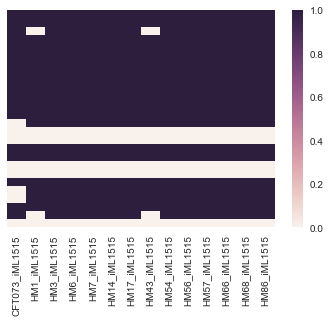

In [51]:
sns.heatmap(cond, yticklabels=False)
plt.show()

//anaconda/lib/python3.6/site-packages/matplotlib/cbook.py:136 MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.


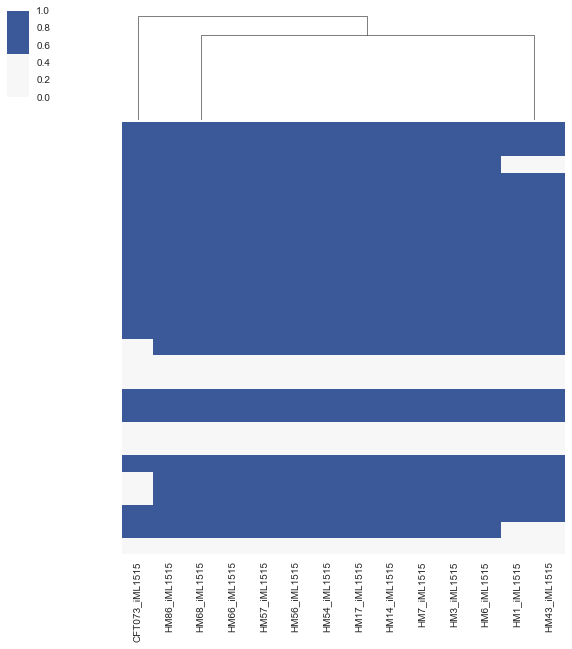

In [49]:
simulation = cond
simulation.head()
strain_cluster = scipy.cluster.hierarchy.linkage(simulation.T)
cmap = mpl.colors.ListedColormap(["#f7f7f7", "#3b5998"])
g = sns.clustermap(simulation, row_cluster=False, col_linkage=strain_cluster,cmap=cmap);
g.ax_heatmap.set_yticklabels('', rotation = 0, fontsize = 8);
#map = mpl.colors.ListedColormap(["#f7f7f7","#3b5998"])
#g = sns.clustermap(simulation,  col_cluster=False, cmap=cmap);
g

In [52]:
ae_all, an_all = simulateCarbonSources(strains, models)

cobra/util/solver.py:419 UserWarning: solver status is 'infeasible'


In [59]:
cond_all = pd.concat([ae_all, an_all], axis = 0)
cond_all[cond_all >0] = 1
cond_all.tail()

,CFT073_iML1515,HM1_iML1515,HM3_iML1515,HM6_iML1515,HM7_iML1515,HM14_iML1515,HM17_iML1515,HM43_iML1515,HM54_iML1515,HM56_iML1515,HM57_iML1515,HM66_iML1515,HM68_iML1515,HM86_iML1515
Uridine exchange,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Xanthine exchange,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Xanthosine 5'-phosphate exchange,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Xanthosine exchange,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Zinc exchange,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


//anaconda/lib/python3.6/site-packages/matplotlib/cbook.py:136 MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.


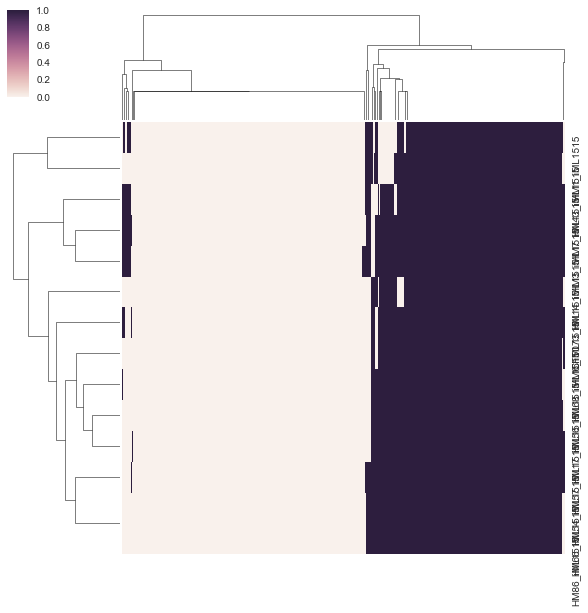

In [61]:
sns.clustermap(cond_all.T, xticklabels=False)
plt.show()

//anaconda/lib/python3.6/site-packages/matplotlib/cbook.py:136 MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.


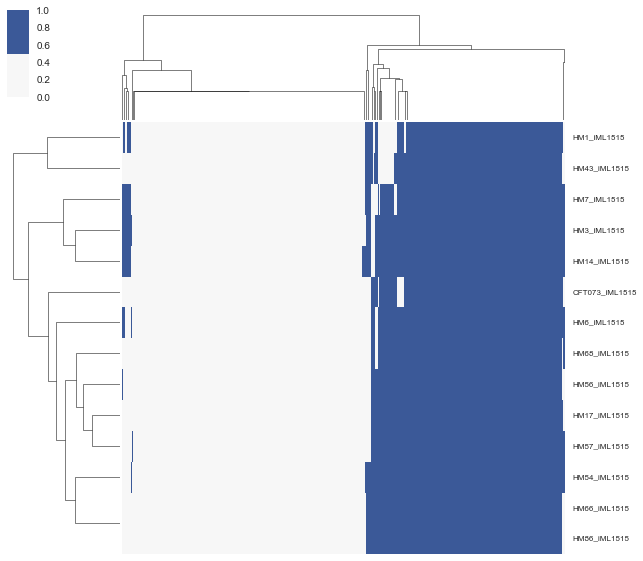

In [65]:
simulation = cond_all.T
strain_cluster = scipy.cluster.hierarchy.linkage(simulation.T)
cmap = mpl.colors.ListedColormap(["#f7f7f7", "#3b5998"])
g = sns.clustermap(simulation,cmap=cmap);
g.ax_heatmap.set_xticklabels('');
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation = 0, fontsize = 8);
#map = mpl.colors.ListedColormap(["#f7f7f7","#3b5998"])
#g = sns.clustermap(simulation,  col_cluster=False, cmap=cmap);
g